In [2]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper
from scipy.stats import ttest_ind

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import freq_bands_eeg, low_qual_chans, subject_id_batch_cage_dict

In [3]:
sns.set_theme()

In [4]:
epoch_folder = select_folder("Select the folder that holds social preference experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

2024-05-08 14:20:01.657 python[15243:606982] +[CATransaction synchronize] called within transaction
2024-05-08 14:20:17.791 python[15243:606982] +[CATransaction synchronize] called within transaction


## Analysis of one subject
Load the epochs of a test subject

In [5]:
subject_id = 39508
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_{subject_id}-epo.fif"), preload=True)

Let's define the channels we wish to investigate

In [6]:
wanted_chans = [chan for chan in epochs.info['ch_names'] if chan not in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [8]:
print(f'There are {len(epochs)} epochs for subject {subject_id}')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "novel_cup"])} are novel cup interactions epochs')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "familiar_cup"])} are familiar cup interactions epochs')

There are 100 epochs for subject 39508
68 are novel cup interactions epochs
32 are familiar cup interactions epochs


The Epoch Array metadata contains further information on how the epochs were created. Let's take a look.

In [8]:
epochs.metadata

,subject_id,genotype,interaction_n,interaction_part_n,interaction_kind,total_interaction_duration,epoch_length
2,39508,DRD2-WT,1,3,novel_cup,6.169,1.0
3,39508,DRD2-WT,1,4,novel_cup,6.169,1.0
4,39508,DRD2-WT,1,5,novel_cup,6.169,1.0
7,39508,DRD2-WT,2,1,novel_cup,4.302,1.0
8,39508,DRD2-WT,2,2,novel_cup,4.302,1.0
...,...,...,...,...,...,...,...
145,39508,DRD2-WT,34,5,novel_cup,4.734,1.0
146,39508,DRD2-WT,35,1,familiar_cup,1.667,1.0
147,39508,DRD2-WT,35,2,familiar_cup,1.667,1.0
149,39508,DRD2-WT,36,2,familiar_cup,3.935,1.0


The metadata contains the interaction identifier. So all rows where *interaction_n* == 1 is data of one single interaction with in this case the novel cup (see *interaction_kind* column).

The *interaction_part_n* tells you something about where along the total interaction duration that specific epoch is located.

### Define power -> decibel calculation function

In [7]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

### Plot the individual epoch powers

In [10]:
psds_sub_novel, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'novel_cup'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='ERROR'
)
psds_sub_familiar, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'familiar_cup'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='ERROR'
)

In [11]:
psds_sub_novel.shape

(68, 1, 101)

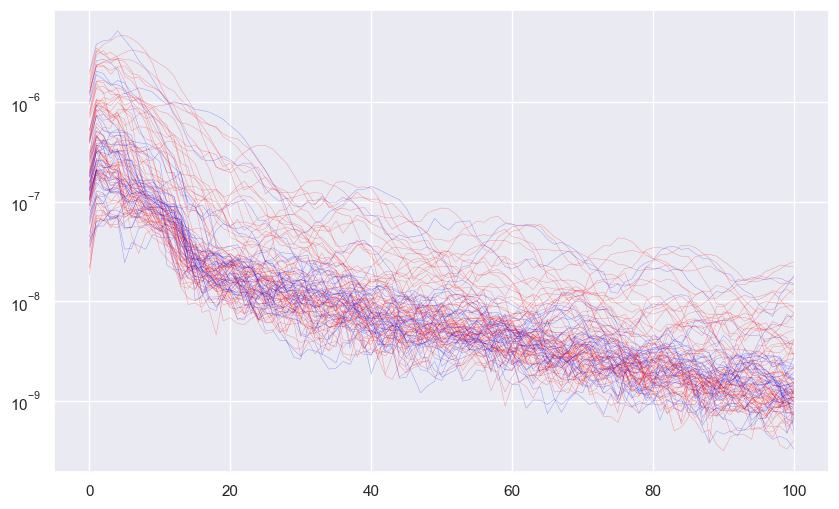

In [12]:
fig = plt.figure(figsize=(10, 6))

for i in range(psds_sub_novel.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_novel[i, 0, :], alpha=0.4, linewidth=.3, color='red')
    
for i in range(psds_sub_familiar.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_familiar[i, 0, :], alpha=0.4, linewidth=.3, color='blue')
    
plt.yscale('log')
plt.show()

### Power Spectral Density (PSD) calculation

In [13]:
df = pd.DataFrame()

for interaction_type in epochs.metadata.interaction_kind.unique():
    
    subject_data = epochs[epochs.metadata["interaction_kind"] == interaction_type]
    subject_id = subject_data.metadata["subject_id"].iloc[0]
    genotype = subject_data.metadata["genotype"].iloc[0]
    
    for channel in wanted_chans:
        # skip plotting data of bad quality
        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            subject_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_data.info['sfreq'],
            n_jobs=-1,
            verbose='ERROR'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]
        
        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
        
        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd (means)": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
            "interaction_kind": interaction_type,
        })])

Let's inspect it a bit

In [14]:
df.head()

,freq,psd (means),psd (norm),subject_id,genotype,channel,interaction_kind
0,0.0,3.194195e-07,0.046953,39508,DRD2-WT,OFC_R,novel_cup
1,1.0,6.394127e-07,0.092847,39508,DRD2-WT,OFC_R,novel_cup
2,2.0,6.331214e-07,0.086653,39508,DRD2-WT,OFC_R,novel_cup
3,3.0,5.766079e-07,0.076237,39508,DRD2-WT,OFC_R,novel_cup
4,4.0,6.008502e-07,0.078242,39508,DRD2-WT,OFC_R,novel_cup


And now we plot the novel cup vs familiar cup powers for all channels. As we're only looking at one subject, we cannot yet compare genotype differences

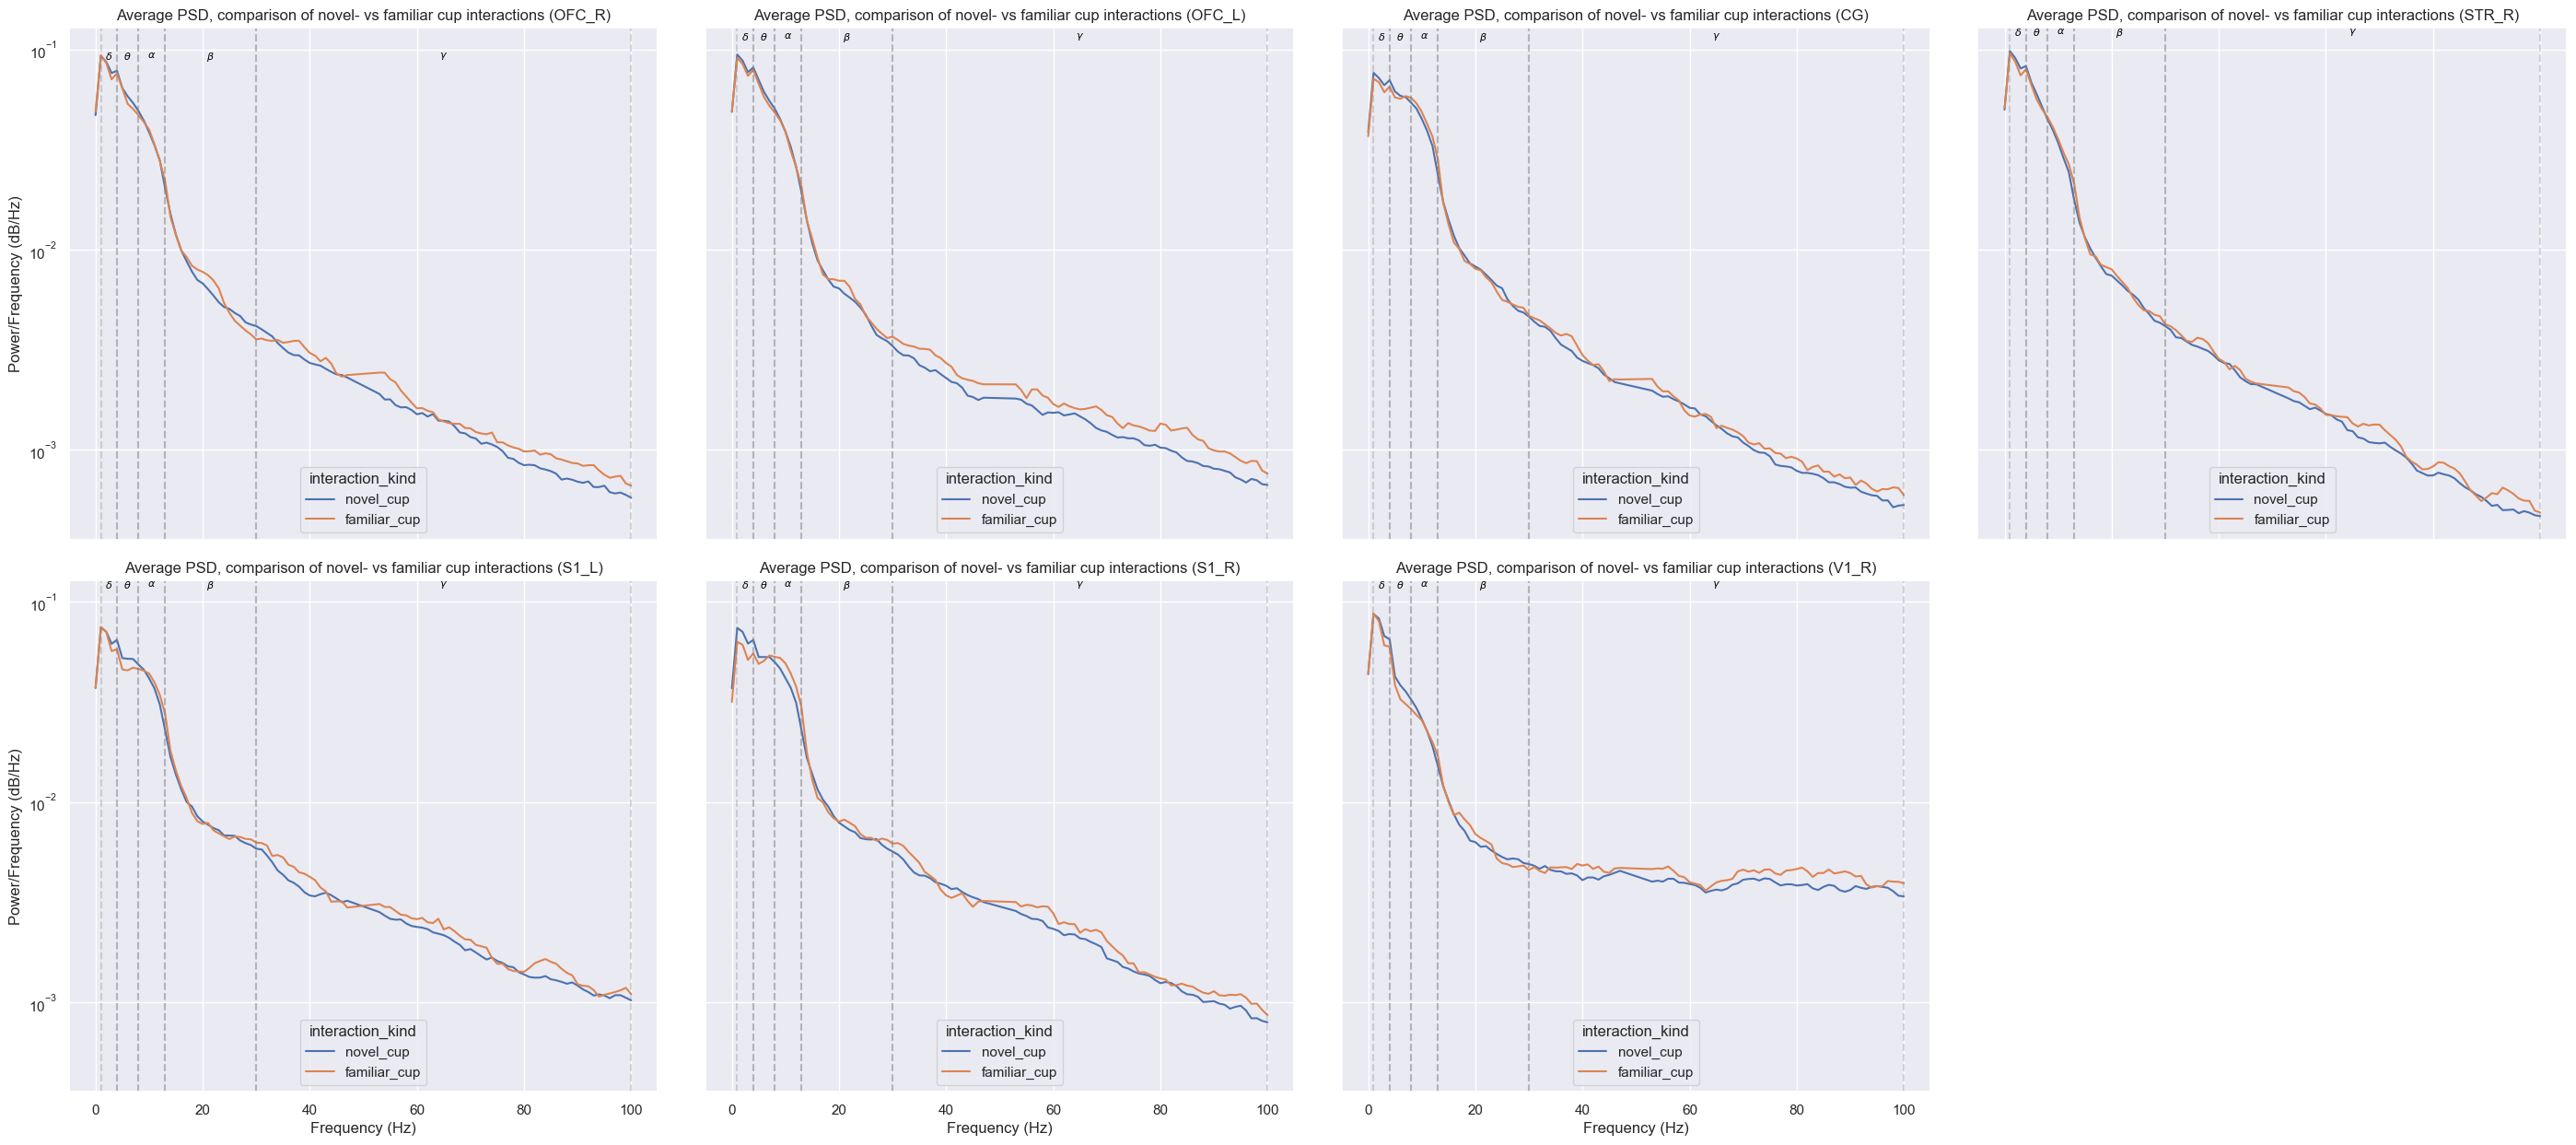

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="interaction_kind", legend=True, ax=axs[i], errorbar='se')
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(f'Average PSD, comparison of novel- vs familiar cup interactions ({channel})')

plt.subplots_adjust(wspace=0.08, hspace=0.08)
axs[-1].remove()
plt.show()

## Analysis of all subjects

First we load all the epoch files

In [8]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='ERROR'))

In [9]:
len(all_subject_epochs)

18

Let's calculate the PSDs again, but now for all animals

In [61]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]
    
    for interaction_type in subject_epochs.metadata.interaction_kind.unique():
        
        subject_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == interaction_type]
        
        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='ERROR'
            )
            decibels = nanpow2db(psds_sub)
                        
            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]

            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)
            
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "interaction_kind": interaction_type,
            })])
        
    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


Let's check if the dataframe contains what we think it does: all subjects, two types of interactions and the genotypes

In [62]:
print(f'Unique subjects: {df.subject_id.unique()} (n={len(df.subject_id.unique())})')
print(f'The genotypes: {np.unique([df[df.subject_id == subject_id].genotype.iloc[0] for subject_id in df.subject_id.unique()], return_counts=True)}')
print(f'Unique interactions: {df.interaction_kind.unique()}')

Unique subjects: ['80625' '81175' '39489' '79604' '81218' '78233' '81193' '78244' '79592'
 '79593' '78211' '78227' '81217' '81207' '80630' '80620' '39508' '79602'] (n=18)
The genotypes: (array(['DRD2-KO', 'DRD2-WT'], dtype='<U7'), array([10,  8]))
Unique interactions: ['novel_cup' 'familiar_cup']


So there are 10 KOs and 8 WTs

First, let's make an overview grid plot of each subject's power over the frequencies per channel

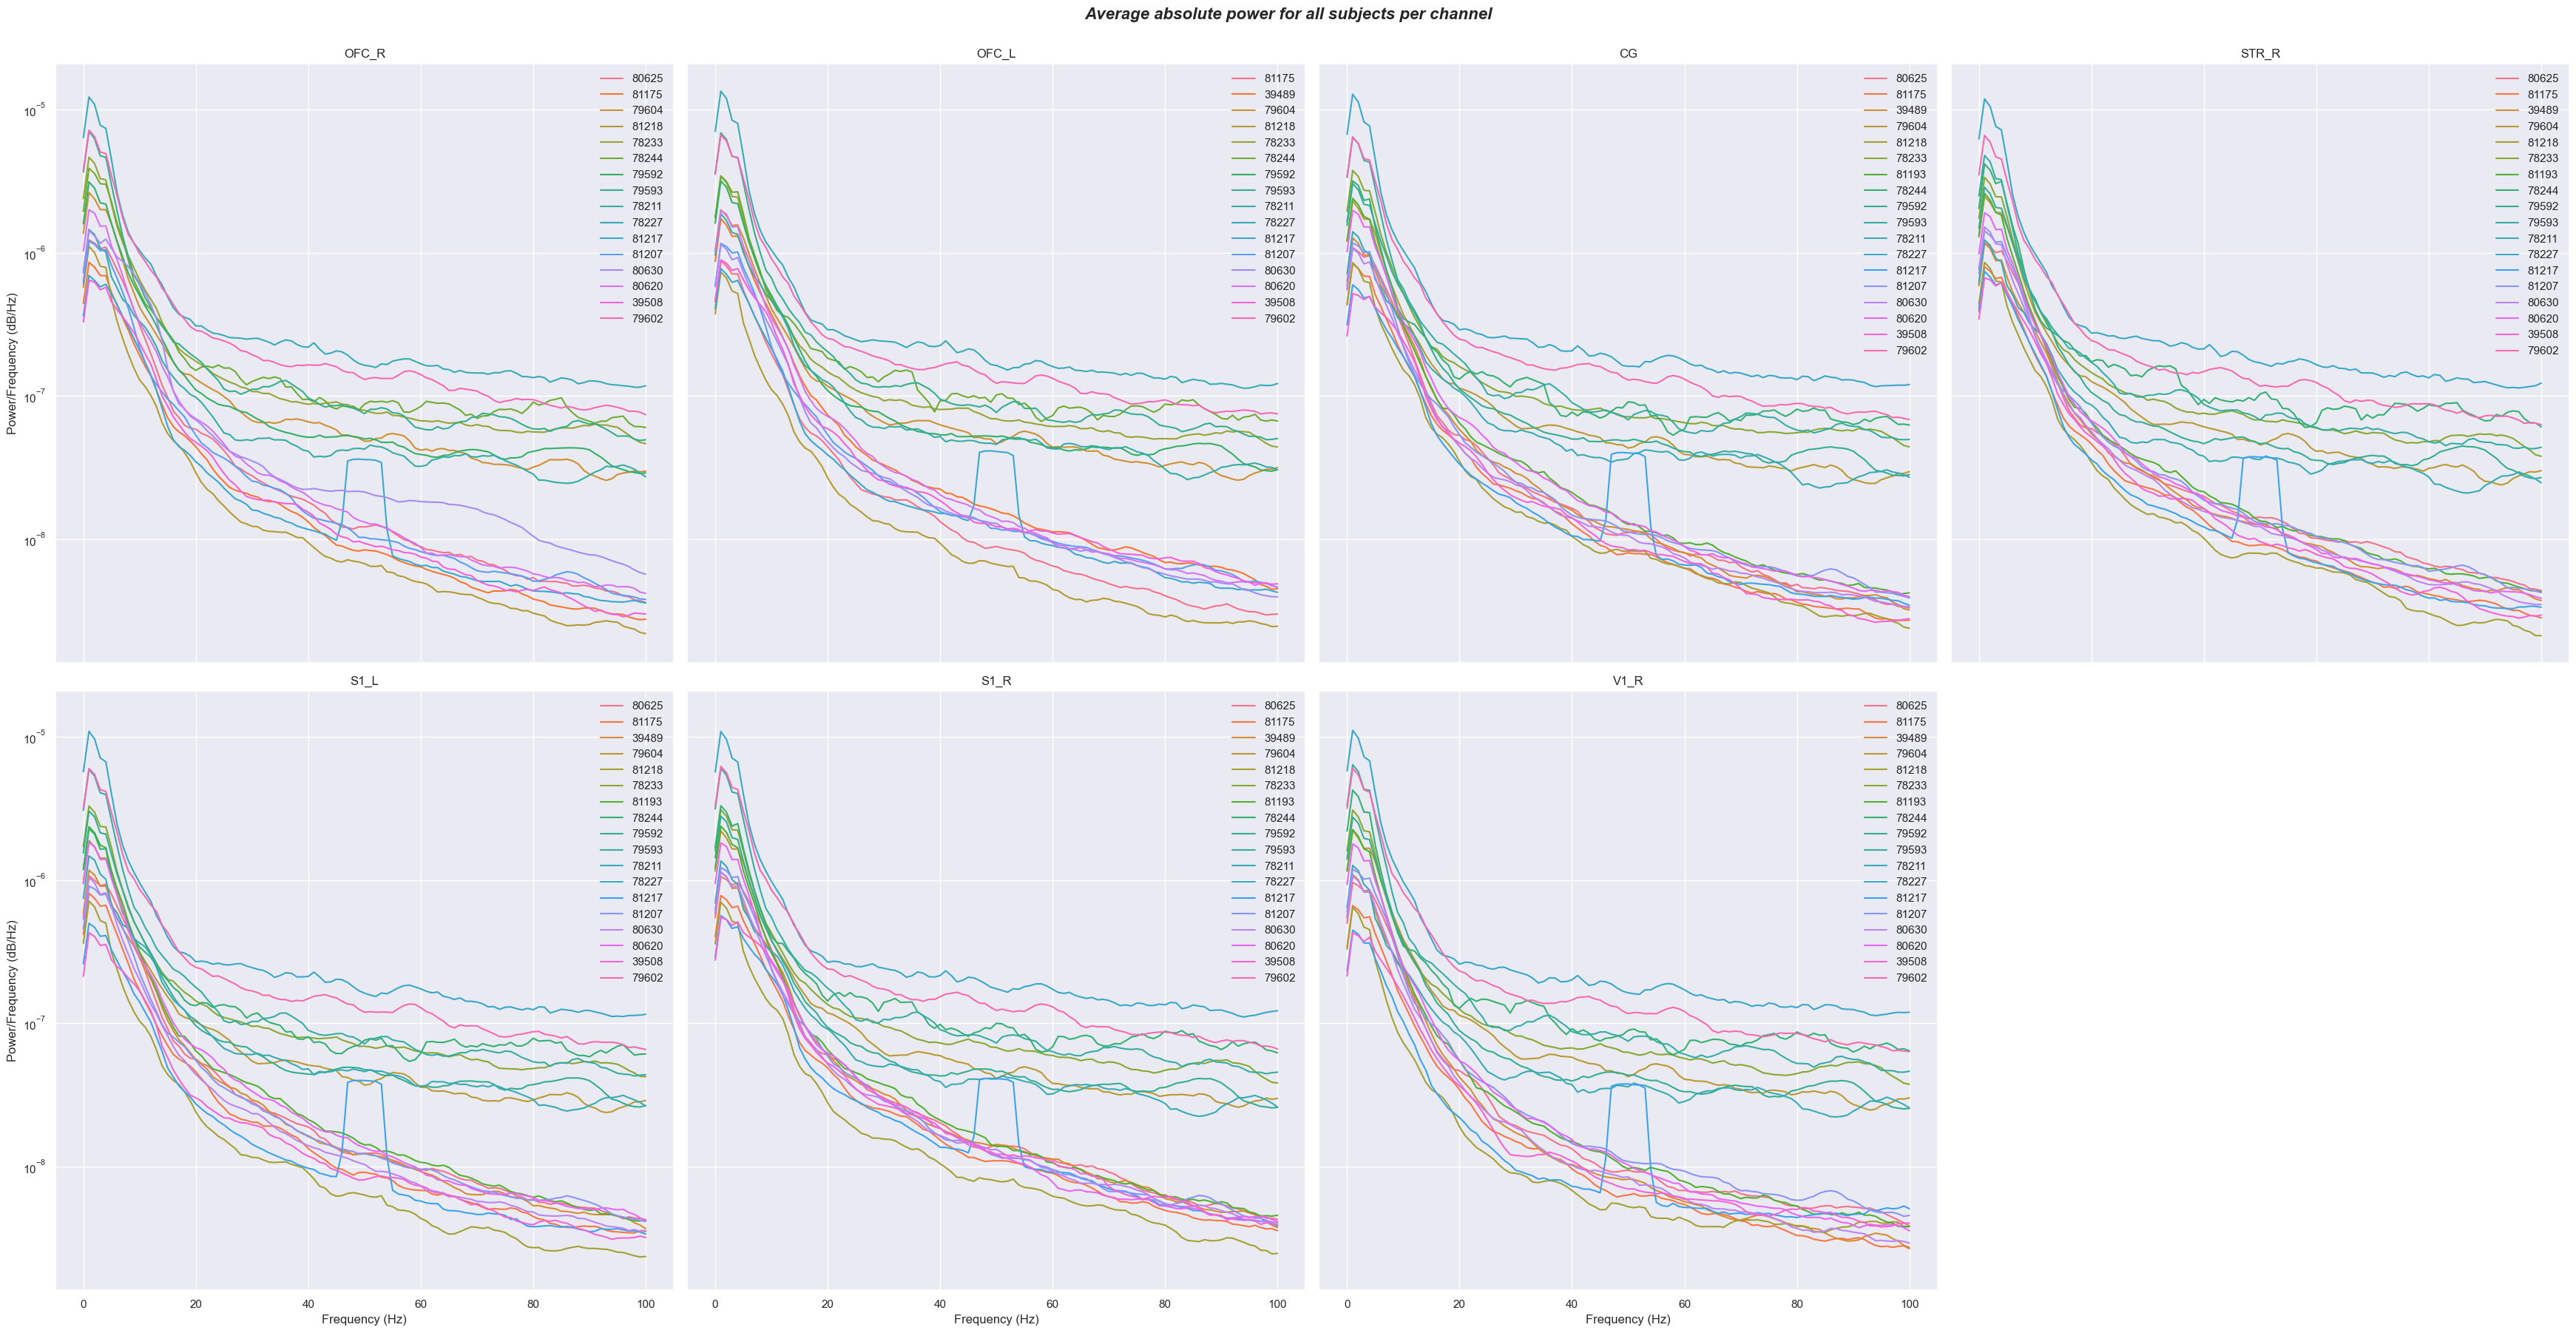

In [63]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    sns.lineplot(channel_data, y='psd', x='freq', hue='subject_id', ax=axs[i], errorbar=None)
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    'Average absolute power for all subjects per channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

Some animals' EEG has been recorded at a way higher sampling frequency than the rest, which called for resampling to still enable us to directly compare the animals. This results in two clearly separable groups when it comes to absolute powers, even after the resampling to 500Hz.

Let's see what it looks like when we normalize the power over the frequencies of each animal by its total power (normalization).

In [64]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    'Average normalized power for all subjects per channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/norm_powers_all_subjects.pdf'))

The two groups seem less separable, though, you can still kind of tell them apart.

Let's see what the normalized decibel trajectories look like.

In [65]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    sns.lineplot(channel_data, y='decibels (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)
    
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power in decibels (dB)')
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    'Average normalized power (in decibels) for all subjects per channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/norm_powers_decibel_all_subjects.pdf'))

It seems like there's, even after normalization, some kind of separation to be made in the powers (high gamma). This likely has to do with the resampling. The subjects that have higher power in the high gammas are probably the subjects that were recorded at a sampling frequency of ~19000 Hz instead of ~1084 Hz.

Later on, when comparing all WTs to all KOs, this artifact in the powers might undermine the credibility of the comparison. That is why we will also use ratios to compare the genotypes.

Furthermore, 81217 looks quite ugly, let's remove that one for now. 

We proceed with creating a grid plot that holds a subplot for each channel that displays the average power of the two different kinds of interactions

In [66]:
df = df[df.subject_id != '81217']
df.subject_id.unique()

array(['80625', '81175', '39489', '79604', '81218', '78233', '81193',
       '78244', '79592', '79593', '78211', '78227', '81207', '80630',
       '80620', '39508', '79602'], dtype=object)

In [67]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="interaction_kind", legend=True, ax=axs[i], errorbar='se')
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    'Average power of all novel cup and familiar cup interaction epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/average_norm_interaction_powers.pdf'))

Let's also do this for the to decibel transformed power values

In [68]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='decibels', hue="interaction_kind", legend=True, ax=axs[i], errorbar='se')
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Decibels (dB)')
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    'Average power in decibels of all social cup and non-social cup interaction epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'eeg_power_analysis/average_norm_interaction_powers_decibels.pdf'))

There's no difference in average power when batching all novel interaction epochs and all familiar interaction epochs, however, there might be a hidden genotype effect that cancels out in the averaging displayed above.

### Are there genotype differences in power in either interaction type?

Now plot the normalized power per interaction type and make the genotype distinction.

In [69]:
for interaction_kind in df.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df[df.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar='se')
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        axs[i].legend(frameon=False, loc='best')
        
    plt.suptitle(f'Average power during {"familiar cup interaction" if interaction_kind == "familiar_cup" else "novel cup interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_norm_genotype_powers_{interaction_kind}.pdf'))

Now, instead of batching all WT or KO epochs together and averaging the power, we will average the power of each subject, and then average the WT subjects their powers and the KO subjects their powers

In [70]:
for interaction_kind in df.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df[df.interaction_kind == interaction_kind]
    
    # get the subject's averages for every frequency of each channel 
    subject_averages = interaction_data.groupby(['subject_id', 'channel', 'freq']).agg({
        'psd': 'mean', 
        'psd (norm)': 'mean',
        'genotype': 'first'
    }).reset_index()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = subject_averages[subject_averages.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power during {"novel cup interaction" if interaction_kind == "novel_cup" else "familiar cup interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_subj_averages_norm_genotype_powers_{interaction_kind}.pdf'))

Let's again do the same for the power values that were converted to decibels (log scale already)

In [71]:
for interaction_kind in df.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df[df.interaction_kind == interaction_kind]
    
    subject_averages = interaction_data.groupby(['subject_id', 'channel', 'freq']).agg({
        'decibels': 'mean', 
        'decibels (norm)': 'mean',
        'genotype': 'first'
    }).reset_index()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = subject_averages[subject_averages.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='decibels (norm)', hue="genotype", legend=True, ax=axs[i], errorbar='se')
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power in decibels (dB)')
        axs[i].set_title(channel)
        axs[i].legend(frameon=False, loc='best')
        
    plt.suptitle(f'Average power (in decibels) during {"novel cup interaction" if interaction_kind == "novel_cup" else "familiar cup interaction"} DRD2-WT vs DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_subj_averages_norm_genotype_powers_decibel{interaction_kind}.pdf'))

While some slight differences seem to arise, we cannot fully trust these outcomes. As mentioned before, even after normalizing power values, there seems to be a difference in average powers when comparing batch 1 and 2 to the rest.

### Power ratios to compare the two genotypes
Now, we calculate a ratio between the novel- and familiar-cup powers per subjects, and then take the average of those ratios per genotype. There's no need to normalize in this case, as they're ratios calculated for each subject.

In [72]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    if subject_epochs.metadata.subject_id.iloc[0] == '81217':
        print('Skipping 81217')
        continue
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]

    novel_cup_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == "novel_cup"]
    familiar_cup_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == "familiar_cup"]
    
    for channel in wanted_chans:

        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            novel_cup_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_epochs.info['sfreq'],
            n_jobs=-1,
            verbose='ERROR'
        )
        decibels = nanpow2db(psds_sub)
        mean_decibels_novel = np.mean(decibels[:, 0, :], axis=0)
        mean_psd_sub_novel = np.mean(psds_sub[:, 0, :], axis=0)
        
        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            familiar_cup_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_epochs.info['sfreq'],
            n_jobs=-1,
            verbose='ERROR'
        )
        decibels = nanpow2db(psds_sub)
        mean_decibels_familiar = np.mean(decibels[:, 0, :], axis=0)
        mean_psd_sub_familiar = np.mean(psds_sub[:, 0, :], axis=0)
    
        novel_over_familiar_psd_ratio = mean_psd_sub_novel / mean_psd_sub_familiar
        novel_over_familiar_decibels_ratio = mean_decibels_novel / mean_decibels_familiar

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd_ratio": novel_over_familiar_psd_ratio,
            "decibel_ratio": novel_over_familiar_decibels_ratio,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
        })])

    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Skipping 81217
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


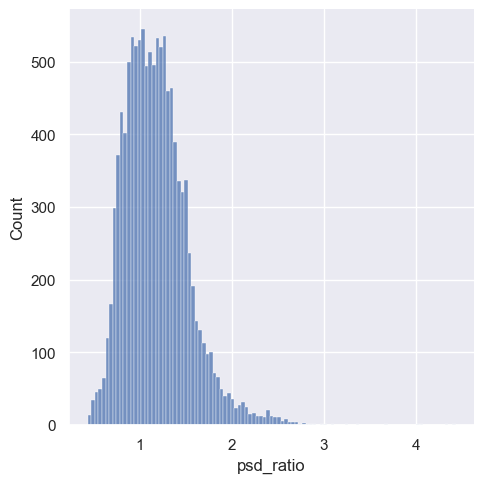

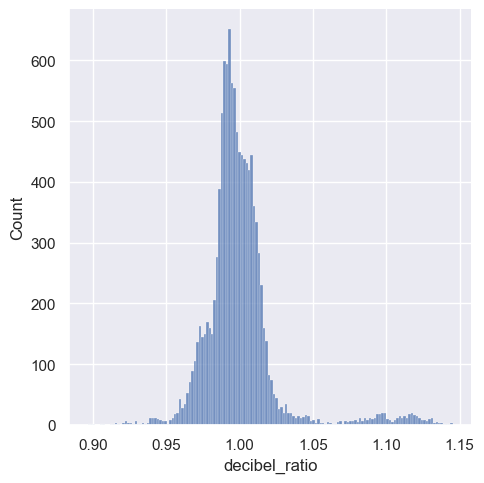

In [73]:
sns.displot(df.psd_ratio)
plt.show()
sns.displot(df.decibel_ratio)
plt.show()

Remove outlier ratios based on IQR method

In [114]:
Q1 = np.percentile(df.psd_ratio, 25)
Q3 = np.percentile(df.psd_ratio, 75)

IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

df = df[(df['psd_ratio'] >= lower_bound) & (df['psd_ratio'] <= upper_bound)]

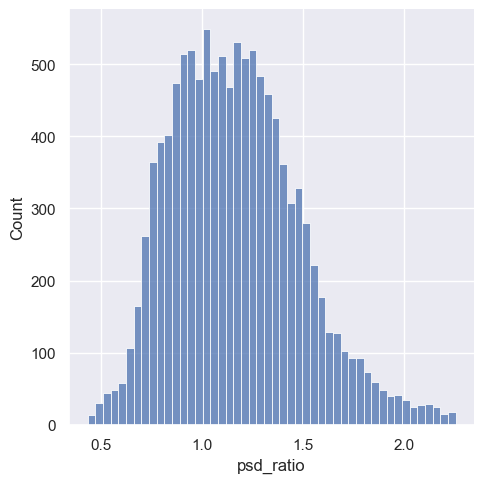

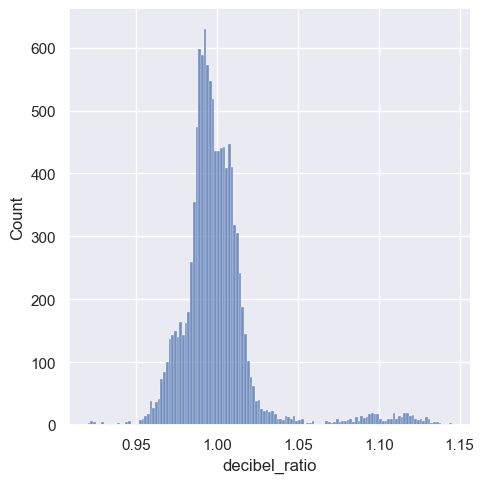

In [115]:
sns.displot(df.psd_ratio)
plt.show()
sns.displot(df.decibel_ratio)
plt.show()

Now that the outliers are gone, we plot the averaged novel cup over familiar cup power ratios of all subjects of the two genotypes.

In [74]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
    sns.lineplot(data=channel_data, x='freq', y='psd_ratio', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
    axs[i].axhline(y=1, linestyle='-', alpha=.5, color='gray')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Normalized Power Ratio')
    axs[i].set_title(f'{channel}')
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    "Novel- over familiar-cup power ratio, DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/norm_power_ratios_per_chan.pdf'))

Also do this for the decibels

In [75]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    
    palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
    sns.lineplot(data=channel_data, x='freq', y='decibel_ratio', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1], band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
    axs[i].axhline(y=1, linestyle='-', alpha=.5, color='gray')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(f'{channel}')
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    "Novel- over familiar-cup power ratio (in decibels), DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/norm_decibel_power_ratios_per_chan.pdf'))

In [76]:
df

,freq,psd_ratio,decibel_ratio,subject_id,genotype,channel
0,0.0,2.459065,0.941828,80625,DRD2-KO,OFC_R
1,1.0,2.495242,0.939658,80625,DRD2-KO,OFC_R
2,2.0,2.505553,0.940970,80625,DRD2-KO,OFC_R
3,3.0,2.519876,0.943075,80625,DRD2-KO,OFC_R
4,4.0,2.442829,0.942536,80625,DRD2-KO,OFC_R
...,...,...,...,...,...,...
96,96.0,1.375108,1.000303,79602,DRD2-WT,V1_R
97,97.0,1.465661,1.000979,79602,DRD2-WT,V1_R
98,98.0,1.292594,1.004919,79602,DRD2-WT,V1_R
99,99.0,1.365835,1.005657,79602,DRD2-WT,V1_R


Let's add the band name to each row

In [77]:
# let's add bad names to the df
for band, (start, end) in freq_bands_eeg.items():
    df.loc[(df['freq'] > start) & (df['freq'] <= end), 'band'] = band

In [78]:
df.head()

,freq,psd_ratio,decibel_ratio,subject_id,genotype,channel,band
0,0.0,2.459065,0.941828,80625,DRD2-KO,OFC_R,NaN
1,1.0,2.495242,0.939658,80625,DRD2-KO,OFC_R,NaN
2,2.0,2.505553,0.940970,80625,DRD2-KO,OFC_R,$\delta$
3,3.0,2.519876,0.943075,80625,DRD2-KO,OFC_R,$\delta$
4,4.0,2.442829,0.942536,80625,DRD2-KO,OFC_R,$\delta$


Now we group the data of each subject and each band within the subject and average the psd_ratio per band

In [79]:
df_grouped = df.groupby(['subject_id', 'channel', 'band']).agg({'psd_ratio': 'mean', 'decibel_ratio': 'mean', 'genotype': 'first'}).reset_index()
df_grouped.head()

,subject_id,channel,band,psd_ratio,decibel_ratio,genotype
0,39489,CG,$\alpha$,0.895033,0.997065,DRD2-KO
1,39489,CG,$\beta$,1.066404,0.994538,DRD2-KO
2,39489,CG,$\delta$,1.135159,0.990639,DRD2-KO
3,39489,CG,$\gamma$,1.244618,0.988769,DRD2-KO
4,39489,CG,$\theta$,0.961103,0.999454,DRD2-KO


In [80]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharey=True, sharex=True)
axs = axs.ravel()

palette_dark = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}
palette_light = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}

for i, channel in enumerate(wanted_chans):
    
    df_grouped_chan = df_grouped[df_grouped.channel == channel]
    
    sns.boxplot(data=df_grouped_chan, x='band', y='psd_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], palette=palette_dark, showfliers=False, order=freq_bands_eeg.keys())
    
    sns.swarmplot(data=df_grouped_chan, x='band', y='psd_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], dodge=True, palette=palette_light, color="white", edgecolor="auto", s=6, legend=False, order=freq_bands_eeg.keys())
    
    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    "Boxplot of novel- over familiar-cup power ratio per band, DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/boxplot_power_ratios_per_band.pdf'))

And the same for the decibels again

In [81]:
fig, axs = plt.subplots(2, 4, figsize=(35, 14), sharex=True)
axs = axs.ravel()

palette_dark = {'DRD2-WT': '#6A8D73', 'DRD2-KO': '#984447'}
palette_light = {'DRD2-WT': '#AEC2B3', 'DRD2-KO': '#C68083'}

for i, channel in enumerate(wanted_chans):
    df_grouped_chan = df_grouped[df_grouped.channel == channel]

    sns.boxplot(data=df_grouped_chan, x='band', y='decibel_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], palette=palette_dark, showfliers=False, order=freq_bands_eeg.keys())

    sns.swarmplot(data=df_grouped_chan, x='band', y='decibel_ratio', hue='genotype', hue_order=['DRD2-WT', 'DRD2-KO'], ax=axs[i], dodge=True, palette=palette_light, color="white", edgecolor="auto", s=6, legend=False, order=freq_bands_eeg.keys())

    axs[i].set_title(channel)
    axs[i].legend(frameon=False, loc='best')

plt.suptitle(
    "Boxplot of novel- over familiar-cup power ratio (in decibels) per band, DRD2-WT versus DRD2-KO", 
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/boxplot_power_ratios_decibel_per_band.pdf'))

Let's perform some statistics on the psd_ratio to compare WT and KO

In [82]:
df_grouped_wt = df_grouped[df_grouped.genotype == 'DRD2-WT']
df_grouped_ko = df_grouped[df_grouped.genotype == 'DRD2-KO']

for channel in wanted_chans:
    for band in freq_bands_eeg.keys():
        data_wt = df_grouped_wt[(df_grouped_wt.channel == channel) & (df_grouped_wt.band == band)]['psd_ratio']
        data_ko = df_grouped_ko[(df_grouped_ko.channel == channel) & (df_grouped_ko.band == band)]['psd_ratio']
        
        print(channel, band, ':', ttest_ind(data_wt, data_ko).pvalue)

OFC_R $\delta$ : 0.9629964480577372
OFC_R $\theta$ : 0.6968699263203886
OFC_R $\alpha$ : 0.18610125454900434
OFC_R $\beta$ : 0.13256000926755346
OFC_R $\gamma$ : 0.4304153669426426
OFC_L $\delta$ : 0.20676439037061067
OFC_L $\theta$ : 0.24324793709564255
OFC_L $\alpha$ : 0.7257631974946244
OFC_L $\beta$ : 0.473250900770106
OFC_L $\gamma$ : 0.8637240691479569
CG $\delta$ : 0.5389643170715754
CG $\theta$ : 0.7521405797323556
CG $\alpha$ : 0.5311485358460744
CG $\beta$ : 0.25920393536792946
CG $\gamma$ : 0.802845443104329
STR_R $\delta$ : 0.8302850585442032
STR_R $\theta$ : 0.7415813998217606
STR_R $\alpha$ : 0.8719071218466327
STR_R $\beta$ : 0.3027793659782965
STR_R $\gamma$ : 0.6536615066330707
S1_L $\delta$ : 0.19814952035405442
S1_L $\theta$ : 0.30326239576582903
S1_L $\alpha$ : 0.8302301237979651
S1_L $\beta$ : 0.5690430793332635
S1_L $\gamma$ : 0.9243573846167468
S1_R $\delta$ : 0.5902792969139247
S1_R $\theta$ : 0.6622531298688697
S1_R $\alpha$ : 0.5825008673690877
S1_R $\beta$ : 

In [83]:
df_grouped_wt = df_grouped[df_grouped.genotype == 'DRD2-WT']
df_grouped_ko = df_grouped[df_grouped.genotype == 'DRD2-KO']

for channel in wanted_chans:
    for band in freq_bands_eeg.keys():
        data_wt = df_grouped_wt[(df_grouped_wt.channel == channel) & (df_grouped_wt.band == band)]['decibel_ratio']
        data_ko = df_grouped_ko[(df_grouped_ko.channel == channel) & (df_grouped_ko.band == band)]['decibel_ratio']
        
        print(channel, band, ' p-value: ', ttest_ind(data_wt, data_ko).pvalue)

OFC_R $\delta$  p-value:  0.6314674628211715
OFC_R $\theta$  p-value:  0.8650259234370834
OFC_R $\alpha$  p-value:  0.255982551709485
OFC_R $\beta$  p-value:  0.1074015282724391
OFC_R $\gamma$  p-value:  0.1508790399859885
OFC_L $\delta$  p-value:  0.36821713441365655
OFC_L $\theta$  p-value:  0.33291373122128176
OFC_L $\alpha$  p-value:  0.7380772458931806
OFC_L $\beta$  p-value:  0.3789867772503003
OFC_L $\gamma$  p-value:  0.2074891408206104
CG $\delta$  p-value:  0.2942675390838552
CG $\theta$  p-value:  0.6088308105748451
CG $\alpha$  p-value:  0.5737702130210263
CG $\beta$  p-value:  0.2115107920996686
CG $\gamma$  p-value:  0.14040237479013787
STR_R $\delta$  p-value:  0.604247770733481
STR_R $\theta$  p-value:  0.7136811077700544
STR_R $\alpha$  p-value:  0.9247994026354228
STR_R $\beta$  p-value:  0.26880829746449636
STR_R $\gamma$  p-value:  0.12616890769141947
S1_L $\delta$  p-value:  0.35712509353149835
S1_L $\theta$  p-value:  0.7014944984612203
S1_L $\alpha$  p-value:  0.

## Let's separate the batches on sampling frequency and batch all social epochs again

For this experiment, batches 1, 2, 3, and 4 were recorded at a sampling frequency of 19525 Hz. Batches 5, 5b and 6 were recorded at a sampling frequency of 1084.72 Hz.

In [10]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:
    
    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]
    
    for interaction_type in subject_epochs.metadata.interaction_kind.unique():
        
        subject_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == interaction_type]
        
        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            decibels = nanpow2db(psds_sub)
            
            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]
        
            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)
            
            # normalize the raw psds
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "interaction_kind": interaction_type,
            })])
        
    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


In [11]:
df.shape

(24644, 9)

In [12]:
ids_high_sf = [str(key) for key, value in subject_id_batch_cage_dict.items() if 'batch1' in value or 'batch2' in value]
print(ids_high_sf)

['78211', '79593', '78233', '79592', '78227', '79604', '78244', '79602']


In [13]:
df_high_sf = df[df.subject_id.isin(ids_high_sf)]
df_low_sf = df[~df.subject_id.isin(ids_high_sf)]

Let's inspect

In [14]:
df_high_sf.head()

,freq,psd,psd (norm),decibels,decibels (norm),subject_id,genotype,channel,interaction_kind
0,0.0,0.000003,0.061595,-60.696490,-0.008169,79604,DRD2-KO,OFC_R,familiar_cup
1,1.0,0.000007,0.122111,-57.577332,-0.007746,79604,DRD2-KO,OFC_R,familiar_cup
2,2.0,0.000006,0.107839,-58.017773,-0.007807,79604,DRD2-KO,OFC_R,familiar_cup
3,3.0,0.000005,0.087933,-58.731728,-0.007901,79604,DRD2-KO,OFC_R,familiar_cup
4,4.0,0.000005,0.086085,-58.771401,-0.007906,79604,DRD2-KO,OFC_R,familiar_cup


In [15]:
df_low_sf.head()

,freq,psd,psd (norm),decibels,decibels (norm),subject_id,genotype,channel,interaction_kind
0,0.0,0.000003,0.063227,-61.783680,-0.007929,80625,DRD2-KO,OFC_R,novel_cup
1,1.0,0.000005,0.125012,-58.768522,-0.007539,80625,DRD2-KO,OFC_R,novel_cup
2,2.0,0.000005,0.117304,-59.000818,-0.007569,80625,DRD2-KO,OFC_R,novel_cup
3,3.0,0.000004,0.096665,-59.635700,-0.007652,80625,DRD2-KO,OFC_R,novel_cup
4,4.0,0.000003,0.094694,-59.668206,-0.007657,80625,DRD2-KO,OFC_R,novel_cup


### High sampling frequency batches

How many of each genotype in the high frequency batches?

In [16]:
np.unique(df_high_sf[(df_high_sf.freq == 1.0) & (df_high_sf.channel == 'OFC_R') & (df_high_sf.interaction_kind == 'novel_cup')].genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([5, 3]))

So, there are 5 KOs and 3 WTs in the first 2 batches. Let's plot the difference in social epoch power between the two genotypes again.

In [17]:
for interaction_kind in df_high_sf.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df_high_sf[df_high_sf.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power of {interaction_kind} interactions - DRD2-WT versus DRD2-KO - High sampling frequency batches (n WT = 3, n KO = 4)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_{interaction_kind}_batches_1_and_2.pdf'))

There seems to be something going on here in the higher frequencies (beta and gamma).

### Low sampling frequency batches

Now, let's do the same for the low sampling frequency batches.

How many of each genotype in the lower frequency batches?

In [18]:
np.unique(df_low_sf[(df_low_sf.freq == 1.0) & (df_low_sf.channel == 'STR_R') & (df_low_sf.interaction_kind == 'novel_cup')].genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([5, 5]))

In [19]:
for interaction_kind in df_high_sf.interaction_kind.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    interaction_data = df_low_sf[df_low_sf.interaction_kind == interaction_kind]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = interaction_data[interaction_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Average power of {interaction_kind} interactions - DRD2-WT versus DRD2-KO - High sampling frequency batches (n WT = 5, n KO = 5)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_{interaction_kind}_batches_4-6.pdf'))